In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

%run animal_info
ANIMAL = 'AC_12102016'

#animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']


dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_213','BS_214']
unuseddualanimals = ['BS_78']

dualanimals = ['BS_174','BS_179','BS_191','BS_192']
retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
didlearnopsinanimals = ['BS_92','BS_103','BS_111','BS_179']
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminateopsinanimals = ['BS_139','BS_165','BS_191','BS_192']

# Generate Dataset to test CNO Verification correctness

In [40]:
DIR = "C:\\Users\\insan\\Desktop\\CNOTest"

staticcells = 10
responsivecells = 10
mua = 10
noise = 10

maxID = 300
maxChan = 64
FR = 10
fs = 30000
maxTime = 60*60;

In [41]:
spike_clusters = []
spike_times = []

In [42]:
unitIDs = random.sample(range(maxID),staticcells+responsivecells+mua+noise)
channels = random.choices(range(maxChan),k=len(unitIDs))

for i in range(staticcells):
    unitID = unitIDs[i]
    
    numberSpikes = maxTime * FR
    maxSample = maxTime * fs
    currentSpikeTimes = np.random.rand(numberSpikes)*maxSample
    currentSpikeIDs = np.ones(numberSpikes)*unitID
    spike_times = np.concatenate((spike_times,currentSpikeTimes))
    spike_clusters = np.concatenate((spike_clusters,currentSpikeIDs))
    
for i in range (responsivecells):
    unitID = unitIDs[i+staticcells]
    
    numberSpikes = maxTime * FR
    maxSample = maxTime * fs
    currentSpikeTimes = np.random.rand(numberSpikes)*maxSample
    currentSpikeIDs = np.ones(numberSpikes)*unitID
    
    numberSpikes = int((maxTime * FR)/2)
    maxSample = int((maxTime * fs)/2)
    currentSpikeTimes2 = np.random.rand(numberSpikes)*maxSample+maxSample
    currentSpikeIDs2 = np.ones(numberSpikes)*unitID
    
    spike_times = np.concatenate((spike_times,currentSpikeTimes,currentSpikeTimes2))
    spike_clusters = np.concatenate((spike_clusters,currentSpikeIDs,currentSpikeIDs2))
        
for i in range(mua):
    unitID = unitIDs[i+staticcells+responsivecells]
    
    numberSpikes = maxTime * FR
    maxSample = maxTime * fs
    currentSpikeTimes = np.random.rand(numberSpikes)*maxSample
    currentSpikeIDs = np.ones(numberSpikes)*unitID
    spike_times = np.concatenate((spike_times,currentSpikeTimes))
    spike_clusters = np.concatenate((spike_clusters,currentSpikeIDs))
    
for i in range(noise):
    unitID = unitIDs[i+staticcells+responsivecells+mua]
    
    numberSpikes = np.random.rand() * (2 * maxTime * FR)
    currentSpikeTimes = np.random.rand(int(numberSpikes))*maxSample
    currentSpikeIDs = np.ones(int(numberSpikes))*unitID
    spike_times = np.concatenate((spike_times,currentSpikeTimes))
    spike_clusters = np.concatenate((spike_clusters,currentSpikeIDs))
    
perm = np.random.permutation(range(len(spike_times)))
spike_times = (spike_times[perm]).astype(int)
spike_clusters = (spike_clusters[perm]).astype(int)

In [43]:
labels = np.repeat(["-----"],len(unitIDs))
for i in range(len(labels)):
    labels[i] = "good"
for i in range(mua):
    labels[i+staticcells+responsivecells] = "mua"
for i in range(noise):
    labels[i+staticcells+responsivecells+mua] = "noise"

phylabel = pd.DataFrame(np.array([unitIDs,labels]).T,columns=["cluster_id","group"])
KSlabel = pd.DataFrame(np.array([unitIDs,labels]).T,columns=["cluster_id","KSlabel"])
clusterinfo = pd.DataFrame(np.array([unitIDs,channels]).T,columns=["cluster_id","ch"])

In [44]:
np.save(os.path.join(DIR,"spike_times.npy"),spike_times)
np.save(os.path.join(DIR,"spike_clusters.npy"),spike_clusters)
phylabel.to_csv(os.path.join(DIR,"cluster_group.tsv"),sep='\t',index=True,header=True)
KSlabel.to_csv(os.path.join(DIR,"cluster_KSlabel.tsv"),sep='\t',index=True,header=True)
clusterinfo.to_csv(os.path.join(DIR,"cluster_info.tsv"),sep='\t',index=True,header=True)

In [31]:
trials = 100000
baseFR = 0.5
stimFR = 3
triallength = 2.5
stimlength = 1
stimoffset = 0.5
peristimulustimes = np.random.rand(int(baseFR*trials*triallength))*triallength
peristimulustimes = np.concatenate((peristimulustimes,np.random.rand(int(stimFR*trials*stimlength))*stimlength+stimoffset))

m1 = len(peristimulustimes)/trials/triallength
m2 = (baseFR*triallength + stimlength*stimFR)/triallength

print(m1)
print(m2)
                                   
xrange = np.linspace(0,triallength,num=1000)
KDE = gaussian_kde(peristimulustimes,bw_method=0.001).evaluate(xrange)
#KDE = KDE/np.sum(KDE)
#print(np.sum(KDE))
FR = KDE * len(peristimulustimes) / trials

1.7
1.7


Text(0.5, 1.0, 'Simulated unit')

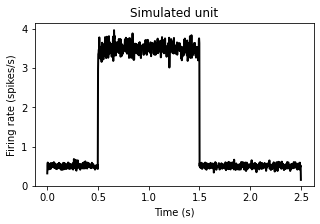

In [32]:
fig,ax = plt.subplots(figsize=(5,3))
ax.plot(xrange,FR,c='k',lw=2)

ylims = ax.get_ylim()
ax.set_ylim([0,ylims[1]])
ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlabel('Time (s)')
ax.set_title('Simulated unit')

# Verify equal amounts of 5k and 11k tone presentations

In [8]:
diffs = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    freqs = sessionfile.trials.freqs
    
    num_5k = np.mean(np.equal(freqs,5648))
    num_11k = np.mean(np.equal(freqs,11260))
    diffs.append(num_5k - num_11k)
    
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    freqs = sessionfile.trials.freqs
    
    num_5k = np.mean(np.equal(freqs,5648))
    num_11k = np.mean(np.equal(freqs,11260))
    diffs.append(num_5k - num_11k)

100%|██████████| 101/101 [00:00<00:00, 135.90it/s]


In [10]:
np.sort(diffs)

array([-0.0960452 , -0.0960452 , -0.09433962, -0.09433962, -0.0877193 ,
       -0.07906977, -0.07906977, -0.07792208, -0.0738255 , -0.0738255 ,
       -0.07246377, -0.07246377, -0.06995885, -0.06995885, -0.06976744,
       -0.06976744, -0.06935123, -0.06935123, -0.06878307, -0.06878307,
       -0.06859206, -0.06859206, -0.06748466, -0.06542056, -0.06451613,
       -0.06265664, -0.06265664, -0.05747126, -0.05732484, -0.05685619,
       -0.05454545, -0.05454545, -0.05376344, -0.05194805, -0.05194805,
       -0.05188679, -0.05188679, -0.05140187, -0.05140187, -0.05102041,
       -0.05102041, -0.04792332, -0.04792332, -0.04738155, -0.04738155,
       -0.04347826, -0.04347826, -0.04347826, -0.04347826, -0.04255319,
       -0.04218362, -0.04218362, -0.04201681, -0.04201681, -0.04121475,
       -0.04121475, -0.04098361, -0.04089219, -0.04089219, -0.04      ,
       -0.04      , -0.03939962, -0.03939962, -0.03926097, -0.03926097,
       -0.03896104, -0.03896104, -0.03854875, -0.03763441, -0.03

# Verify Pseudorandom tone presentation

In [62]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_173_1_tuning_AC.pickle')
sessionfile = ilep.determineTuningCurveTones(sessionfile)

C:\Users\insan\Desktop\FreqListTuningCurve.txt


In [13]:
for session in os.listdir(act_directory):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal != 'BS_188':
        continue
        
    print(session + '\t' + str(ilep.testInOrderTonePresentation(sessionfile)))

BS_188_1_tuning_AC.pickle	False
BS_188_2_tuning_AC.pickle	False
BS_188_3_tuning_AC.pickle	False
BS_188_4_tuning_AC.pickle	False
BS_188_5_tuning_AC.pickle	False
BS_188_6_tuning_AC.pickle	False


In [5]:
for session in os.listdir(act_directory):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal not in ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214']:
        continue
        
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    correct = verifyCorrectTonePresentation(sessionfile)
    print(session + '\t' + str(sessionfile.tuning.number_of_tones) + '\t' + str(correct))

BS_173_10_tuning_AC.pickle	350	1.0
BS_173_1_tuning_AC.pickle	450	1.0
BS_173_2_tuning_AC.pickle	450	1.0
BS_173_3_tuning_AC.pickle	450	1.0
BS_173_4_tuning_AC.pickle	250	1.0
BS_173_5_tuning_AC.pickle	250	1.0
BS_173_6_tuning_AC.pickle	250	1.0
BS_173_7_tuning_AC.pickle	350	1.0
BS_173_8_tuning_AC.pickle	350	1.0
BS_173_9_tuning_AC.pickle	350	1.0
BS_175_10_tuning_AC.pickle	0	nan
BS_175_11_tuning_AC.pickle	350	1.0
BS_175_12_tuning_AC.pickle	0	nan
BS_175_13_tuning_AC.pickle	350	1.0
BS_175_14_tuning_AC.pickle	350	1.0
BS_175_15_tuning_AC.pickle	350	1.0
BS_175_2_tuning_AC.pickle	450	1.0
BS_175_3_tuning_AC.pickle	450	1.0
BS_175_4_tuning_AC.pickle	450	1.0
BS_175_5_tuning_AC.pickle	250	1.0
BS_175_6_tuning_AC.pickle	250	1.0
BS_175_7_tuning_AC.pickle	250	1.0
BS_175_8_tuning_AC.pickle	250	1.0
BS_175_9_tuning_AC.pickle	250	1.0
BS_187_1_tuning_AC.pickle	350	1.0
BS_187_2_tuning_AC.pickle	350	1.0
BS_187_3_tuning_AC.pickle	350	1.0
BS_187_4_tuning_AC.pickle	350	1.0
BS_188_1_tuning_AC.pickle	350	1.0
BS_188_2_tu

In [4]:
def verifyCorrectTonePresentation(sessionfile):
    number_tone_presentations = len(sessionfile.tuning.all_tone_times)
    tuning_tone_idxs = list(range(sessionfile.meta.length_in_trials,number_tone_presentations))
    toneCounts = sessionfile.trials.raw_audio_threshold_crossings[tuning_tone_idxs]
    toneFreqs = toneCounts * 10
    
    tones_present = np.unique(sessionfile.tuning.trial_freqs)
    tones_to_check = tones_present[np.less(tones_present,sessionfile.meta.fs/2)]
    
    if len(tones_to_check)==0:
        return np.nan
    
    tone_errors = []
    for tone in tones_to_check:
        
        this_tone_idxs = np.equal(sessionfile.tuning.trial_freqs,tone)
        
        error = np.less(np.abs(toneFreqs - tone),750)
        error = error[this_tone_idxs]
        
        tone_errors.append(error)
    tone_errors = np.concatenate(tone_errors)
    
    return np.mean(tone_errors)

In [8]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_213_1_tuning_AC.pickle')
sessionfile = ilep.determineTuningCurveTones(sessionfile)

In [9]:
res = verifyCorrectTonePresentation(sessionfile)
print(res)

[ 5670. 14180. 12590.  4390. 11150.  4140.  5510.  2310.  7560.  8500.
 13350. 12980.  4380. 11120.  4140.  5510.  2310.  7560.  8480. 13090.
 12740.  4380. 11110.  4140.  5500.  2320.  7570.  8440. 14250. 12750.
  4400. 11140.  4140.  5520.  2310.  7580.  8490. 13910. 12960.  4410.
 11140.  4140.  5500.  2310.  7570.  8480. 12830. 12910.  4390. 11130.
  4140.  5510.  2300.  7570.  8440. 14260. 12790.  4350. 11090.  4130.
  5510.  2300.  7580.  8500. 13880. 12950.  4360. 11110.  4140.  5510.
  2310.  7580.  8480. 13010. 12970.  4390. 11140.  4150.  5500.  2340.
  7590.  8430. 14260. 12860.  4410. 11130.  4140.  5500.  2340.  7570.
  8500. 13480. 12970.  4390. 11120.  4130.  5510.  2340.  7570.  8440.
 13490. 12900.  4350. 11110.  4140.  5510.  2340.  7570.  8500. 14240.
 12950.  4380. 11130.  4140.  5500.  2330.  7560.  8510. 13130. 12960.
  4390. 11140.  4140.  5520.  2330.  7540.  8450. 13960. 13000.  4400.
 11150.  4140.  5500.  2340.  7550.  8500. 14160. 12990.  4390. 11120.
  4140